In [1]:
import os
import random
import cv2
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.math import log, reduce_mean
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

!pip install patchify
from patchify import patchify

import matplotlib.patches as mpatches

# 1 Patches

In [2]:
root_directory = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/"
patch_size = 256

In [3]:
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        images.sort()
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                
                image = cv2.imread(path+'/'+image_name, 1)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):  
                        single_patch_img = patches_img[i,j,0,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

In [4]:
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                
                mask = cv2.imread(path+'/'+mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):  
                        single_patch_mask = patches_mask[i,j,0,:,:]
                        mask_dataset.append(single_patch_mask)

In [5]:
image_dataset = np.asarray(image_dataset)[:]
mask_dataset = np.asarray(mask_dataset)[:]

print(image_dataset.shape, mask_dataset.shape)

(1305, 256, 256, 3) (1305, 256, 256, 3)


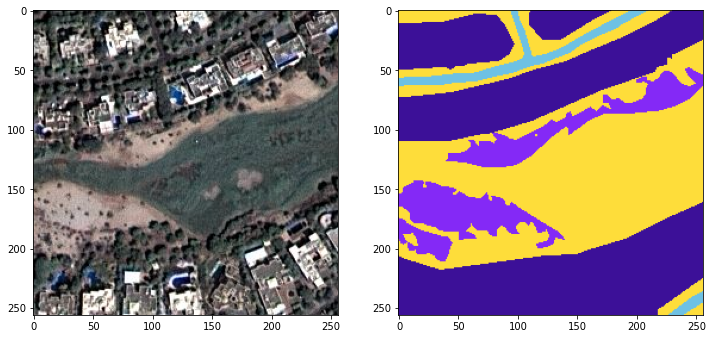

In [6]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

# 2 Labels (RGB to categorical)

In [7]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [8]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.all(label == Unlabeled, axis = -1)] = 0
    label_seg [np.all(label == Land, axis = -1)] = 1
    label_seg [np.all(label == Road, axis = -1)] = 2  
    label_seg [np.all(label == Vegetation, axis = -1)] = 4   
    label_seg [np.all(label == Water, axis = -1)] = 5
    label_seg [np.all(label == Building, axis = -1)] = 3 
    
    label_seg = label_seg[:,:,0]
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

In [9]:
labels = np.array(labels)
labels.shape

(1305, 256, 256)

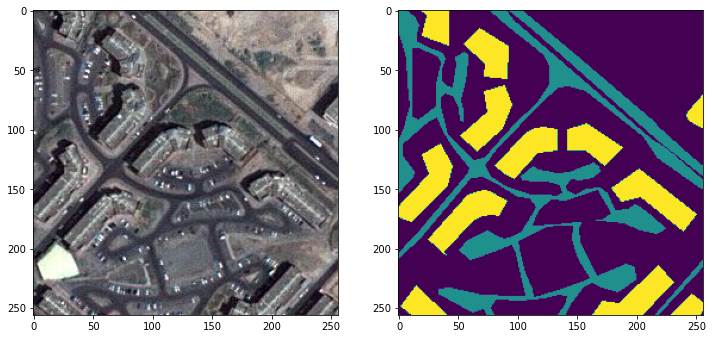

[1 2 3]
(256, 256, 3)
(256, 256)


In [10]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number])
plt.show()

print(np.unique(labels[image_number]))


print(image_dataset[image_number].shape)
print(labels[image_number].shape)

# 3 Model

In [11]:
import albumentations as A

class Augmenter: 
    def __init__(self):
        self.augmentations = [
            A.VerticalFlip(p=1),
            A.Transpose(p=1),
            A.SafeRotate(limit=90, p=1),
            A.RandomSizedCrop(p=1, min_max_height=(128, 128), height=256, width=256)

        ]
    
    def augment(self, image, mask):
        # Select a random augmentation 
        aug = random.sample(self.augmentations,1)[0]
        augmented = aug(image=image, mask=mask)
        return augmented['image'], augmented['mask']
    
augmenter = Augmenter()

In [12]:
print(image_dataset.shape[0])

1305


In [13]:
aug_images = [] 
aug_masks = [] 


indices = random.sample(list(range(image_dataset.shape[0])), 50)
for i in indices: 
    aug_image, aug_mask = augmenter.augment(image_dataset[i], mask_dataset[i])
    aug_images.append(aug_image)
    aug_masks.append(aug_mask)

In [14]:
aug_images = np.asarray(aug_images)
aug_masks = np.asarray(aug_masks)

    
print(aug_images.shape, aug_masks.shape)

(50, 256, 256, 3) (50, 256, 256, 3)


In [15]:
aug_labels = [] 
for i in range(aug_masks.shape[0]):
    label = rgb_to_2D_label(aug_masks[i])
    aug_labels.append(label)

aug_labels = np.asarray(aug_labels)

In [16]:
print()

In [17]:
aug_labels = np.asarray(aug_labels)
labels = np.vstack((labels, aug_labels))
image_dataset = np.vstack((image_dataset, aug_images))


In [18]:
labels_cat = to_categorical(labels)
print(labels.shape)

(1355, 256, 256)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, train_size = 0.8, test_size = 0.2, random_state = 42)

In [20]:
del image_dataset, mask_dataset, labels, labels_cat, aug_labels, aug_images, aug_masks

In [21]:
import keras 
import tensorflow as tf 

def multi_unet_model(n_classes, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu',  padding='same')(c5)
    
    #Expansive path 

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [22]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [23]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = tf.keras.applications.ResNet101(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

model = DeeplabV3Plus(image_size=256, num_classes=6)
model.summary()


2023-01-22 11:25:15.914847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 11:25:16.003709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 11:25:16.004637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 11:25:16.006565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [24]:
from keras import backend as K
def jaccard_distance(y_true, y_pred, smooth=100):
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [25]:
print((y_test[0] == y_test[0]).sum() / (256*256*3*2))

1.0


In [32]:
def dice_coef(y_true, y_pred):
    return K.sum(y_true == y_pred) / (256 * 256 * 3 * 2)

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
               metrics=[dice_coef, "accuracy"]
             )

In [28]:
print(y_test.shape)

(271, 256, 256, 6)


In [29]:
print(y_test[0])

[[[0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]
  ...
  [0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]
  ...
  [0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]
  ...
  [0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]]

 ...

 [[0. 0. 1. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0.]
  ...
  [0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 1. 0. 0.]]

 [[0. 0. 1. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0.]
  ...
  [0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 1. 0. 0.]]

 [[0. 0. 1. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0.]
  ...
  [0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 1. 0. 0.]]]


In [34]:
hist = []
history = model.fit(X_train, y_train, 
                     batch_size=4,
                    verbose=1,
                    epochs=2, 
                    validation_data=(X_test, y_test),
                    callbacks=[
                        tf.keras.callbacks.ReduceLROnPlateau(
                            monitor="val_loss",
                            factor=0.1,
                            patience=10,
                            verbose=1
                        )
                    ]
                    )

hist.append(history)

2023-01-22 11:26:27.109731: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 852492288 exceeds 10% of free system memory.


Epoch 1/2


TypeError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /tmp/ipykernel_631/4210885659.py:2 dice_coef  *
        return K.sum(y_true == y_pred) / (256 * 256 * 3 * 2)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/backend.py:2300 sum
        return tf.reduce_sum(x, axis, keepdims)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:2254 reduce_sum
        _ReductionDims(input_tensor, axis))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:2265 reduce_sum_with_dims
        gen_math_ops._sum(input_tensor, dims, keepdims, name=name))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:10724 _sum
        name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:630 _apply_op_helper
        param_name=input_name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:63 _SatisfiesTypeConstraint
        ", ".join(dtypes.as_dtype(x).name for x in allowed_list)))

    TypeError: Value passed to parameter 'input' has DataType bool not in list of allowed values: float32, float64, int32, uint8, int16, int8, complex64, int64, qint8, quint8, qint32, bfloat16, uint16, complex128, float16, uint32, uint64


In [ ]:
import random

image_numbers = random.sample(list(range(X_test.shape[0])), 1)
print(image_numbers) 

for image_number in image_numbers: 
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    plt.title("True Image")
    plt.imshow(X_test[image_number])
    plt.axis("off")
    
    plt.subplot(132)
    plt.title("True Mask")
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true)
    plt.axis("off")
    
    plt.subplot(133)
    plt.title("Predicted Mask")
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2) + 1
    plt.imshow(prediction)
    plt.axis("off")
    

    # plt.savefig(f"/kaggle/working/deeplabv3plus_{image_number}")
    plt.show()


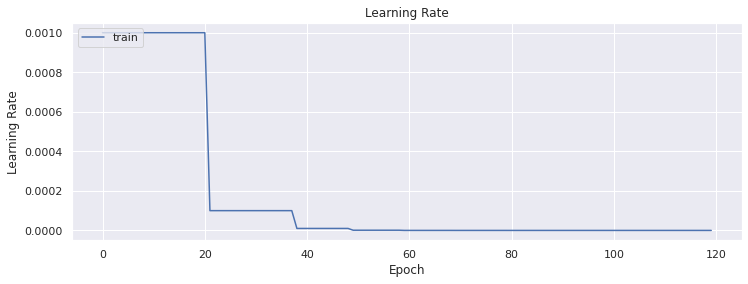

In [82]:
import seaborn as sns
sns.set_theme()

history1 = hist[0]
plt.figure(figsize=(12,4))
plt.plot(history1.history["lr"])
plt.title('Learning Rate')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()